In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 123
BATCH_SIZE = 16
NUM_EPOCHS = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', download=True, transform=preprocess)
test = datasets.MNIST(root='./data', train=False, download=True, transform=preprocess)
classes = dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [4]:
torch.manual_seed(RANDOM_SEED)
train_size = len(dataset)

STEPS_PER_EPOCH = len(dataset) // BATCH_SIZE
STEPS_PER_TEST_EPOCH = len(test) // BATCH_SIZE

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

images.shape: torch.Size([16, 1, 32, 32])


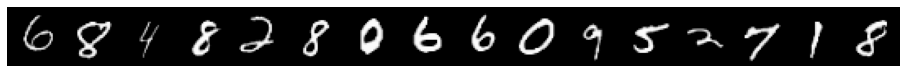

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):        
        x = self.sigmoid(self.conv1(x))
        x = self.avgpool(x)
        
        x = self.sigmoid(self.conv2(x))
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [7]:
model = LeNet()

In [8]:
optimizer = torch.optim.Adam(params=model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
def testing(data_loader):
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return test_loss / total, correct/total*100

In [10]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []

loss_history = []
accuracy_history = []

In [11]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}:")
    for batch_idx, (image, label) in enumerate(train_loader):

        model.train()
        images, labels = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item() / BATCH_SIZE)

        total = 0
        correct = 0
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_history.append(correct / total * 100)

        if (batch_idx+1)%250==0:
            print(f'Batch : {batch_idx+1} | Train_Loss : {sum(loss_history[-250:]) / 250} | Train_Accuracy : {sum(accuracy_history[-250:]) / 250} |', end='\n')
        
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    print(f'Mean loss for this epoch was {avg_train_loss_history[-1]}')
    print(f'Mean accuracy for this epoch was {avg_train_accuracy_history[-1]}')
    print()

    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = testing(test_loader)
        avg_test_loss_history.append(test_loss)
        avg_test_accuracy_history.append(test_acc)
    print(f'Test Loss : {test_loss} | Test Accuracy : {test_acc}')
    print()

Epoch 0:
Batch : 250 | Train_Loss : 0.14292411541938782 | Train_Accuracy : 13.775 |
Batch : 500 | Train_Loss : 0.08786097222566605 | Train_Accuracy : 60.725 |
Batch : 750 | Train_Loss : 0.04342243510484695 | Train_Accuracy : 81.375 |
Batch : 1000 | Train_Loss : 0.03132179729640484 | Train_Accuracy : 86.4 |
Batch : 1250 | Train_Loss : 0.02490392172895372 | Train_Accuracy : 88.9 |
Batch : 1500 | Train_Loss : 0.02039355581998825 | Train_Accuracy : 90.675 |
Batch : 1750 | Train_Loss : 0.018258378428407013 | Train_Accuracy : 91.25 |
Batch : 2000 | Train_Loss : 0.015377899501472711 | Train_Accuracy : 92.925 |
Batch : 2250 | Train_Loss : 0.015367221191991121 | Train_Accuracy : 92.35 |
Batch : 2500 | Train_Loss : 0.012833870058879256 | Train_Accuracy : 94.3 |
Batch : 2750 | Train_Loss : 0.011691590507049113 | Train_Accuracy : 94.275 |
Batch : 3000 | Train_Loss : 0.011961103511508555 | Train_Accuracy : 94.225 |
Batch : 3250 | Train_Loss : 0.012044663050211965 | Train_Accuracy : 94.075 |
Batch :

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss = 0
correct = 0
total = 0
true_labels = []
predictions = []

for batch_idx, (input, target) in enumerate(test_loader):
    inputs, targets = input.to(device), target.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    test_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    true_labels.extend(list(target.numpy()))
    predictions.extend(list(predicted.to("cpu").numpy()))

print(f"Final Test Loss {test_loss / total}")
print(f"Final Test Accuracy {correct/total * 100}")

Final Test Loss 0.0022596203439148666
Final Test Accuracy 98.91


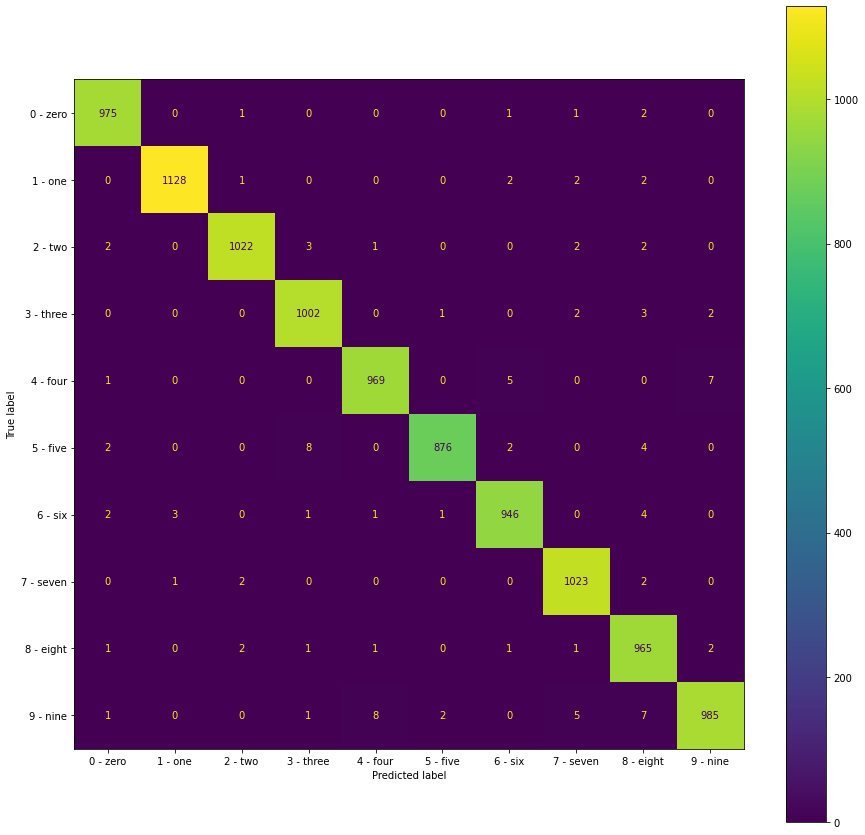

In [13]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)
plt.show()

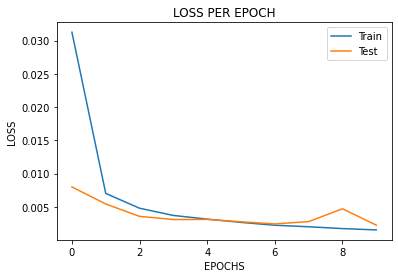

In [14]:
plt.plot(avg_train_loss_history,label = "Train")
plt.plot(avg_test_loss_history , label = "Test")
plt.title('LOSS PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()
plt.show()

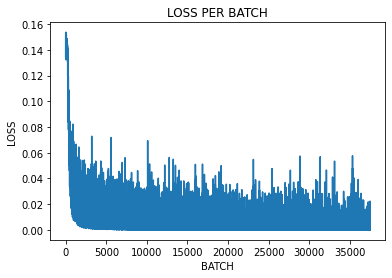

In [15]:
plt.plot(loss_history)
plt.title('LOSS PER BATCH')
plt.xlabel("BATCH")
plt.ylabel("LOSS")
plt.show()

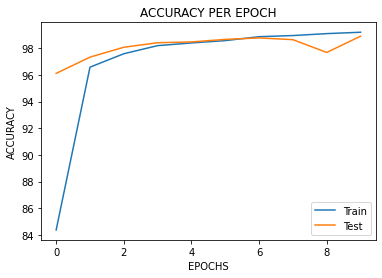

In [16]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()